# Background Removal and Blur through Image Segmentation

First, we add the imports that will be used throughout the entire notebook.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter

We then define some helper functions to help us plot the image results.

In [2]:
# Plot Limit for max images to show in a plot
plot_limit = 20
(rows, cols) = (5, 4)

# Helper function to plot the images in a subplot
def add_img_subplot(index, img, color_mode='rgb'):    
    plt.subplot(rows, cols, index + 1)
    if color_mode == 'grayscale':
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')

def show_subplots(title, imgs, rgb=True):
    plt.figure(figsize=(5, 10))
    for i, img in enumerate(imgs[:plot_limit]):
        add_img_subplot(i, img, color_mode="rgb" if rgb else "grayscale")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

## Transforming the original images

For this part, we will be transforming and loading the images into the memory so that we can perform the image segmentation.

In [3]:
# Create an output folder if it doesn't exist yet
input_folder = 'dataset'
output_folder = "resized"
os.makedirs(output_folder, exist_ok=True)

# Add a file limit so that only a few images are resized
filenames = os.listdir(input_folder)

# Loop over the images in the filenames list and process each image
for i, filename in enumerate(sorted(filenames)):
    filepath = os.path.join(input_folder, filename)
    img = cv2.imread(filepath)

    if img is not None:
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        resized = cv2.resize(blurred, (300, 400))

        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, f"{i:03}.jpeg")
        cv2.imwrite(output_path, resized)
    else:
        print(f"{filename} could not be read.")

We will now plot the resized images so that we can see how they look.

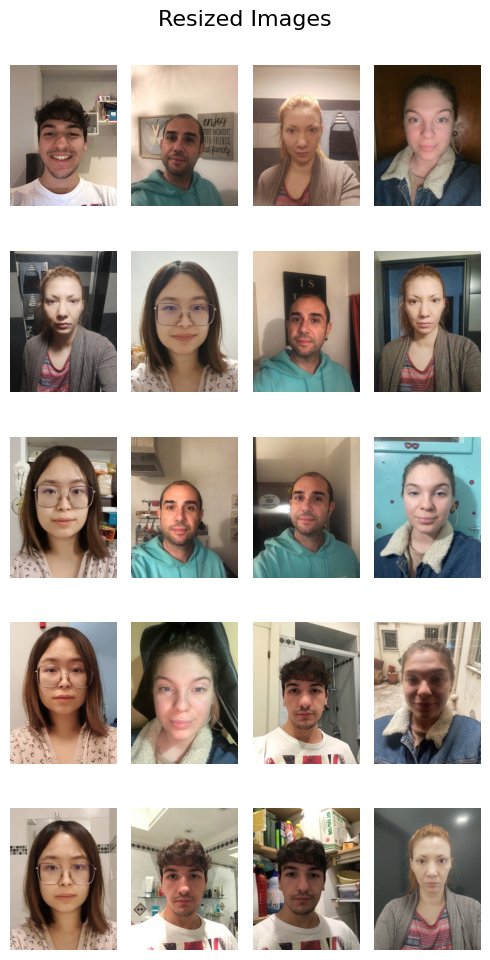

In [136]:
images = []
resized_folder = 'resized'
resized_files = os.listdir(resized_folder)

for i, filename in enumerate(resized_files):
    filepath = os.path.join(resized_folder, filename)
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    images.append(img)

show_subplots("Resized Images", images)

## Edge Detection

For this section of the notebook, we will be using different edge detection methods and compare their performance against one another. We will define a dictionary here to keep track of their speed performance.

In [5]:
timers = dict()

### Edge Detection using Canny Edge Detection

For this section, we will be using Canny Edge Detection to map out the edges of the images.

Here we use the Canny method from cv2, which works with RGB out of the box. This allows us to just plug in the images read from before. We also dilate the results from the edge detection in order to see the edges more clearly. 

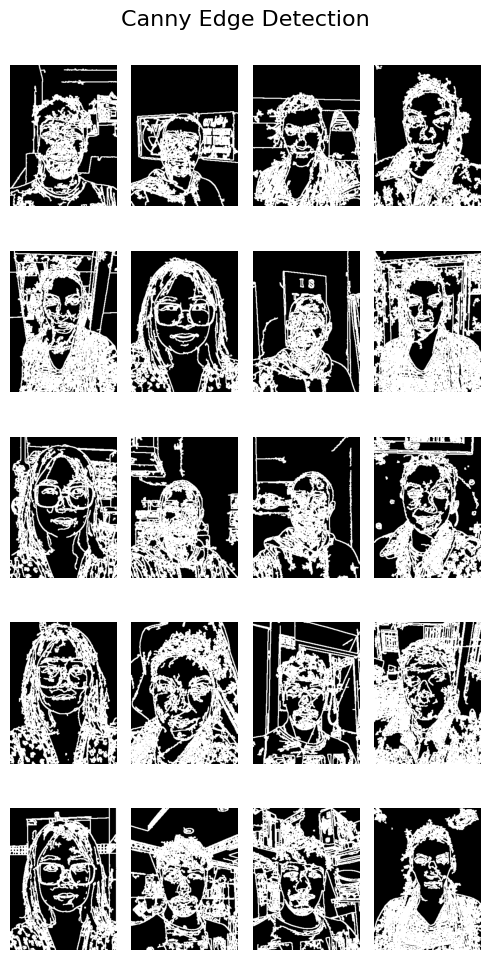

In [6]:
# These thresholds help fine tune the edge detection.
minThresh = 20
maxThresh = 100

# Here we use the canny edge detection.
start = time.time()
canny_edges = [cv2.Canny(img, minThresh, maxThresh) for img in images]

# We only care about the function, so end the timer here.
end = time.time()

# Finally dilate so that edges are clearer.
canny_edges = [cv2.dilate(edge, None) for edge in canny_edges]

timers["canny"] = (end-start) / len(images)

show_subplots("Canny Edge Detection", canny_edges, rgb=False)

### Edge Detection using the Sobel Operator

Here we define an edge detection function that uses the Sobel Operator to map out the edges of the image. This edge detect function uses all of the RGB channels in order to find a more accurate reading of the edges of the image. To start, we will create a new helper function that will be used by all edge detection methods going forward.

In [7]:
# Helper function to get the combination of all edges based on the RGB channels of an image
def get_rgb_edges(edge_func, dilate=True):
    edges = []

    timeTotal = 0

    for img in images:
        start = time.time()
        edgeImg = np.max(np.array([
            edge_func(img[:, :, 0]),
            edge_func(img[:, :, 1]),
            edge_func(img[:, :, 2])
        ]), axis=0)
          
        mean = np.mean(edgeImg)
        # Zero any value that is less than mean. This reduces a lot of noise.
        edgeImg[edgeImg <= mean] = 0

        # End timer here after all the processing
        end = time.time()

        # Get the time taken
        timeTotal += end - start

        # Dilate it to make the edges more visible then append it.
        edges.append(cv2.dilate(edgeImg, None) if dilate else edgeImg)
    
    return (timeTotal, edges)

We then define the edge detection function that will be used for each channel. Additionally, the time performance of the function will be measured here.

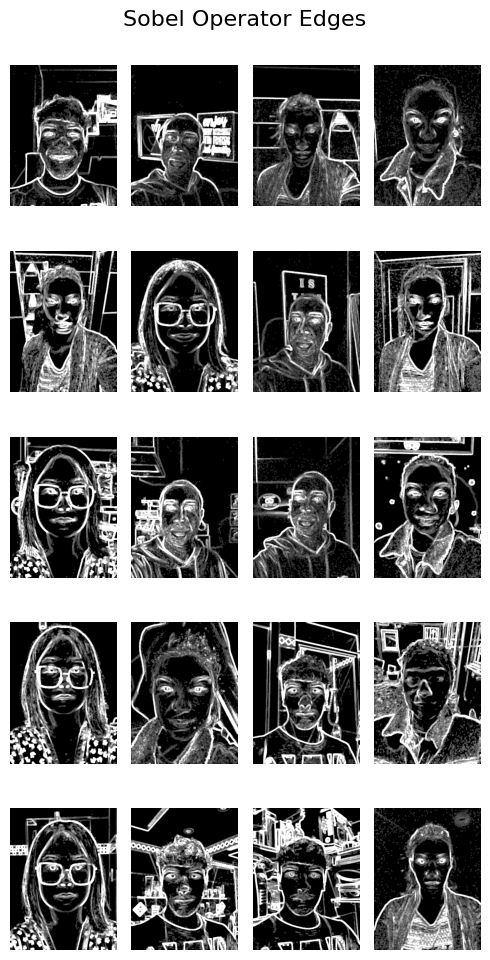

In [8]:
def sobel_edgedetect(channel):
    # Updated cv2.CV_165 to cv2.CV_64F as cv2.CV_165 does not exist.
    sobelX = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_64F, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel

(duration, sobel_edges) = get_rgb_edges(sobel_edgedetect)

timers["sobel"] = duration / len(images)

show_subplots("Sobel Operator Edges", sobel_edges, rgb=False)

### Edge Detection using the Scharr Operator

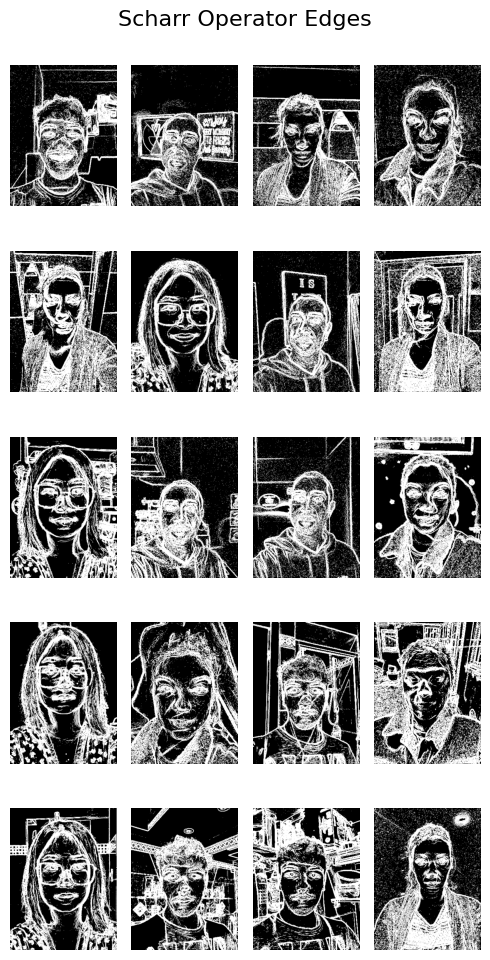

In [9]:
def scharr_edgedetect(channel):
    # Updated cv2.CV_165 to cv2.CV_64F as cv2.CV_165 does not exist.
    scharrX = cv2.Scharr(channel, cv2.CV_64F, 1, 0)
    scharrY = cv2.Scharr(channel, cv2.CV_64F, 0, 1)
    scharr = np.hypot(scharrX, scharrY)
    scharr[scharr > 255] = 255
    return scharr

(duration, scharr_edges) = get_rgb_edges(scharr_edgedetect, dilate=False)

timers["scharr"] = duration / len(images)

show_subplots("Scharr Operator Edges", scharr_edges, rgb=False)

### Edge Detection using Laplace Operator

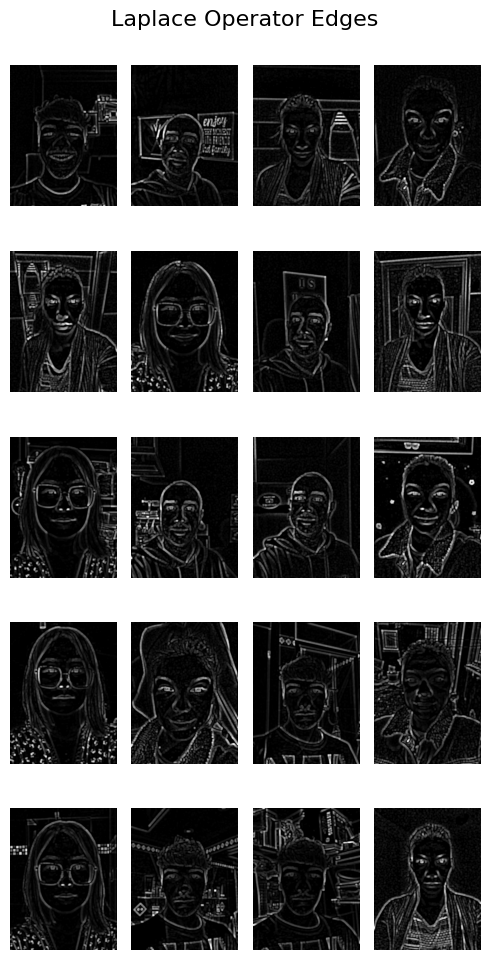

In [10]:
def laplace_edgedetect(channel):
    # Updated cv2.CV_165 to cv2.CV_64F as cv2.CV_165 does not exist.
    laplace = cv2.Laplacian(channel, cv2.CV_64F, ksize=15)
    laplace_abs = np.uint(np.absolute(laplace)) 
    return laplace
# Process all images in the "resized" folder

(duration, laplace_edges) = get_rgb_edges(laplace_edgedetect)

timers["laplace"] = duration / len(images)

show_subplots("Laplace Operator Edges", laplace_edges, rgb=False)

## Drawing the contour using the edges

After finding the edges of the image, we then find the contours that will allow us to create a mask based off the edges. Based off of these contours, we choose the most significant top-level one using the helper function below.

In [11]:
def findSignificantContours (img, edgeImg):
    # Updated the output unpacking as cv2.findContours now returns only two values in recent OpenCV versions.
    contours, heirarchy = cv2.findContours(edgeImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find level 1 contours
    level1 = []
    for i, tupl in enumerate(heirarchy[0]):
        # Each array is in format (Next, Prev, First child, Parent)
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            level1.append(tupl)
 
    # From among them, find the contours with large surface area.
    significant = []
    tooSmall = edgeImg.size * 5 / 100 # If contour isn't covering 5% of total area of image then it probably is too small
    for tupl in level1:
        contour = contours[tupl[0]];

        area = cv2.contourArea(contour)
        if area > tooSmall:

            # Smoothing the contour using Savitsky-Golay filter.
            window_size = int(round(min(img.shape[0], img.shape[1]) * 0.05))

            # Use Savitsky-Golay filter to get the new x and y coordinates
            x = savgol_filter(contour[:,0,0], window_size * 2 + 1, 3)
            y = savgol_filter(contour[:,0,1], window_size * 2 + 1, 3)

            # Create a new contour using the new x and y coordinates
            approx = np.empty((x.size, 1, 2))
            approx[:,0,0] = x
            approx[:,0,1] = y
            approx = approx.astype(int)
            contour = approx

            significant.append([contour, area])

            # Draw the contour on the original image
            cv2.drawContours(img, [contour], 0, (0,255,0),2, cv2.LINE_AA, maxLevel=1)

    significant.sort(key=lambda x: x[1])
    #print ([x[1] for x in significant]);
    return [x[0] for x in significant];   

### Masks using Canny Edge Detection Edges

For this section, we'll be applying the custom significant contour function to the edges obtained using Canny Edge Detection.

In [12]:
def applyMasks(edges):
    contours = []
    masked = []
    blurred = []
    for i, edgeImg in enumerate(edges):
        edgeImg_8u = np.asarray(edgeImg, np.uint8)
        
        # Use the corresponding resized image as the source image for contour drawing
        img = images[i].copy()
        
        # Find contours for each edge image
        contour = findSignificantContours(img, edgeImg_8u)
        contours.append(contour)

        # Apply Masks
        mask = edgeImg.copy()
        mask[mask > 0] = 0
        cv2.fillPoly(mask, contour, 255)
        # Invert mask
        mask = np.logical_not(mask)

        # Create a blurred version only for the masked part of the image
        blurred_img = cv2.GaussianBlur(images[i].copy(), (21, 21), 0)

        # Combine the original image and blurred region based on the mask
        combined_img = images[i].copy()
        combined_img[mask>0] = blurred_img[mask>0]
        blurred.append(combined_img)

        # Finally remove the background
        img[mask] = 0
        masked.append(img)

    return (contours, masked, blurred)

In [13]:
(canny_contours, canny_masked, canny_blurred) = applyMasks(canny_edges)

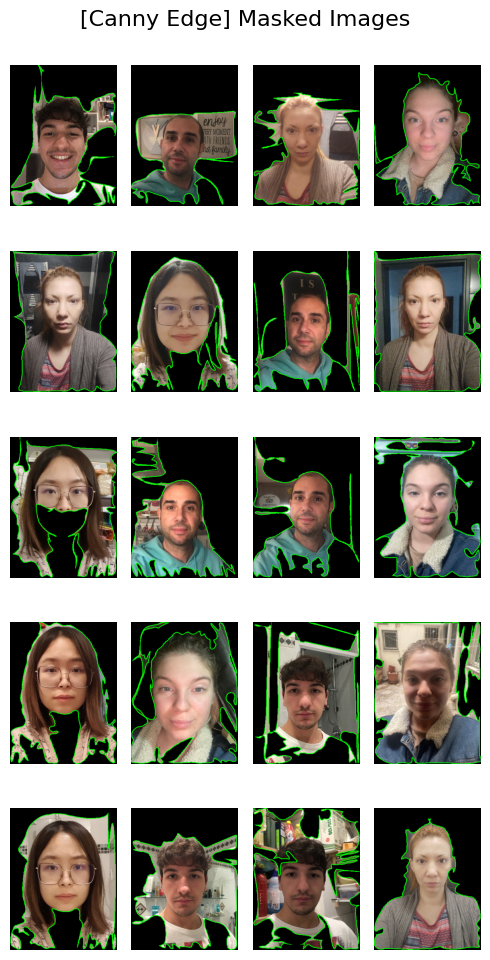

In [14]:
show_subplots("[Canny Edge] Masked Images", canny_masked)

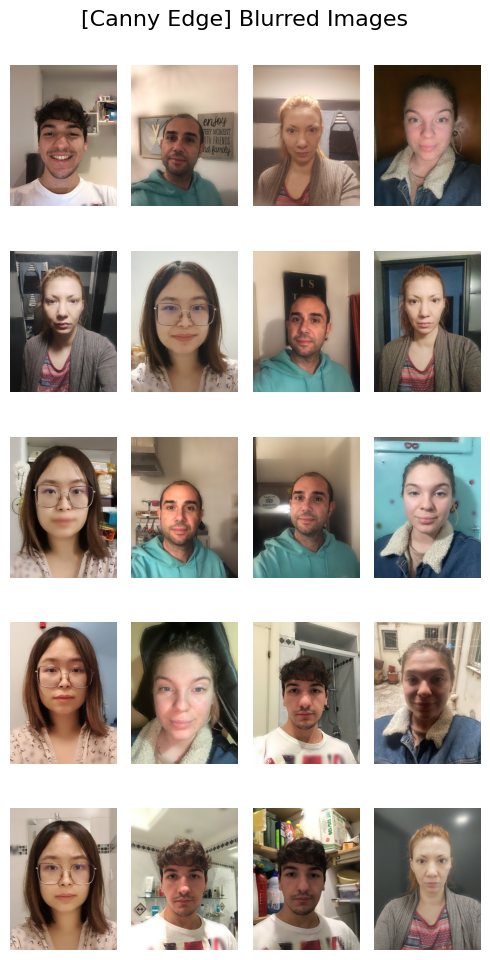

In [15]:
show_subplots("[Canny Edge] Blurred Images", canny_blurred)

### Masks using Sobel Operator Edges

For this section, we'll be applying the custom significant contour function to the edges obtained using the Sobel Operator.

In [16]:
(sobel_contours, sobel_masked, sobel_blurred) = applyMasks(sobel_edges)

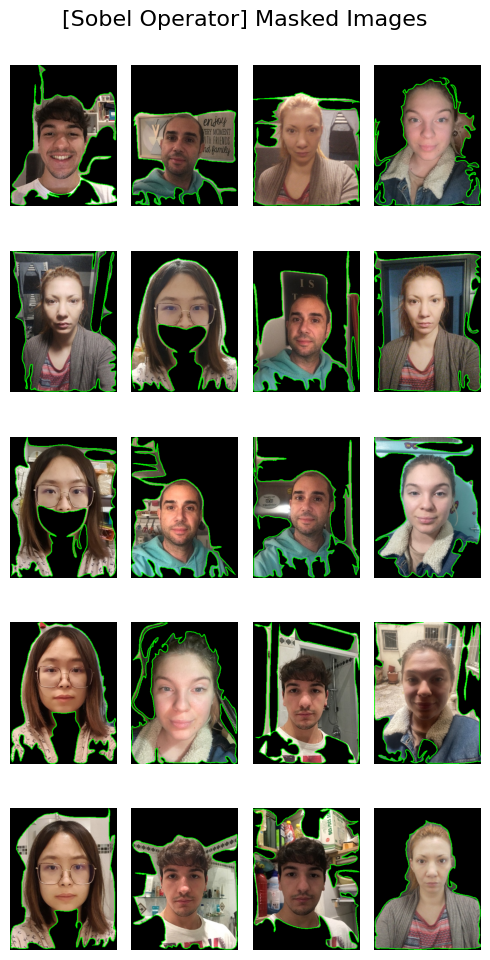

In [17]:
show_subplots("[Sobel Operator] Masked Images", sobel_masked)

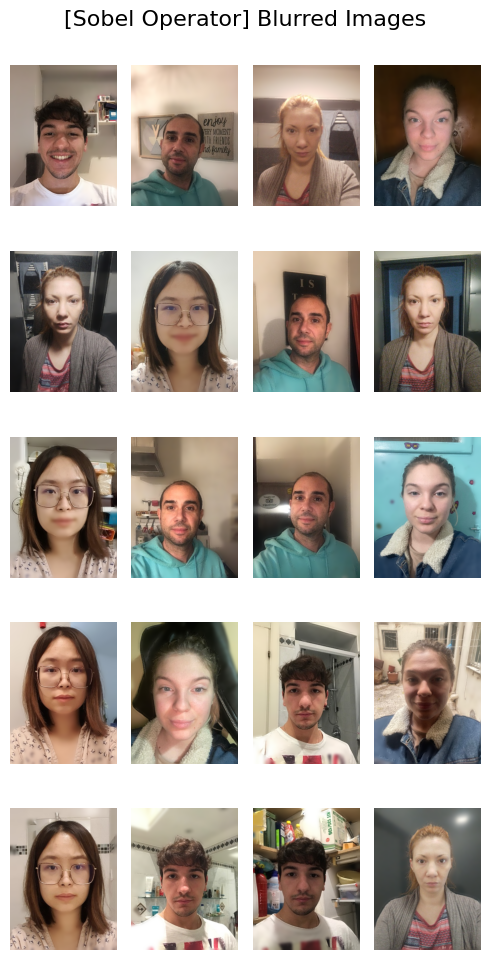

In [18]:
show_subplots("[Sobel Operator] Blurred Images", sobel_blurred)

### Masks using Scharr Operator Edges

In [19]:
(scharr_contours, scharr_masked, scharr_blurred) = applyMasks(scharr_edges)

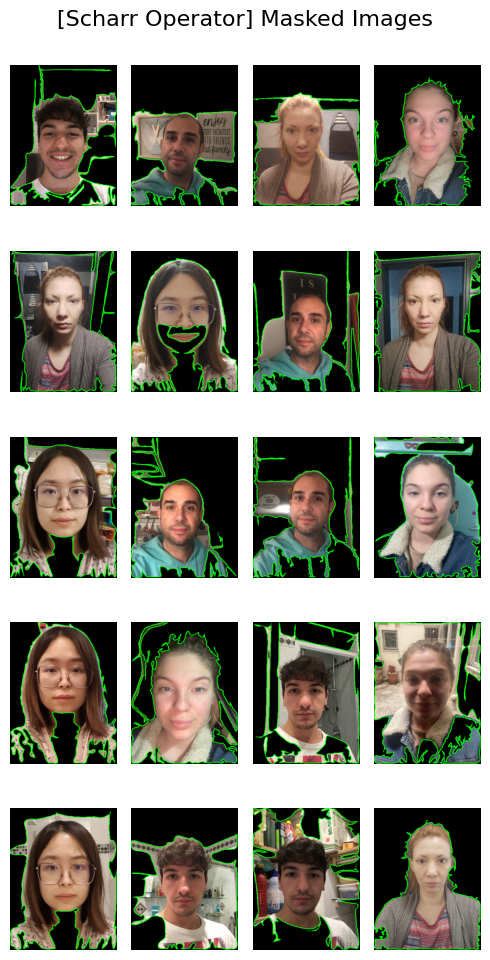

In [20]:
show_subplots("[Scharr Operator] Masked Images", scharr_masked)

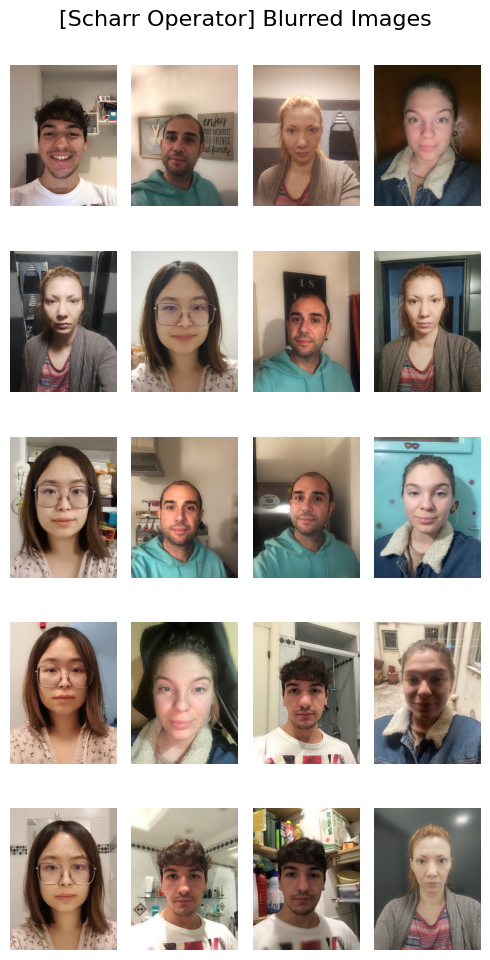

In [21]:
show_subplots("[Scharr Operator] Blurred Images", scharr_blurred)

### Masks using Laplace Operator Edges

In [22]:
(laplace_contours, laplace_masked, laplace_blurred) = applyMasks(laplace_edges)

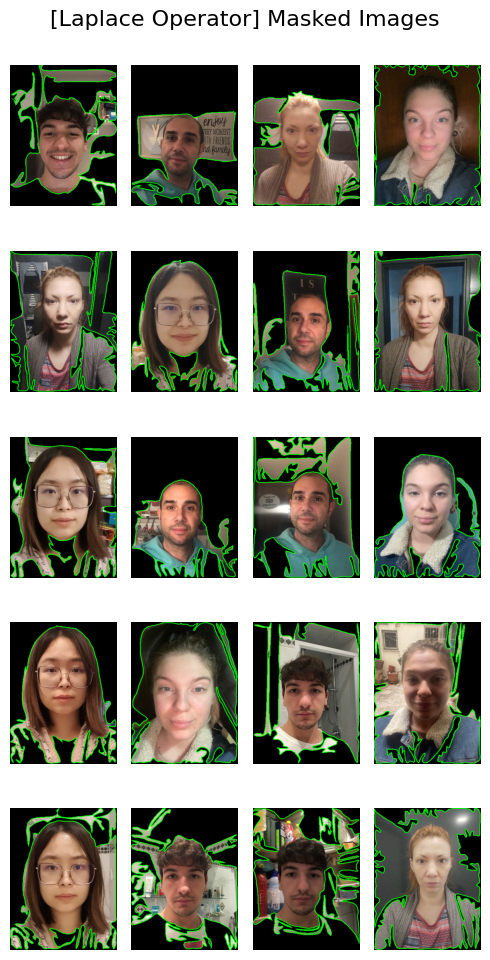

In [23]:
show_subplots("[Laplace Operator] Masked Images", laplace_masked)

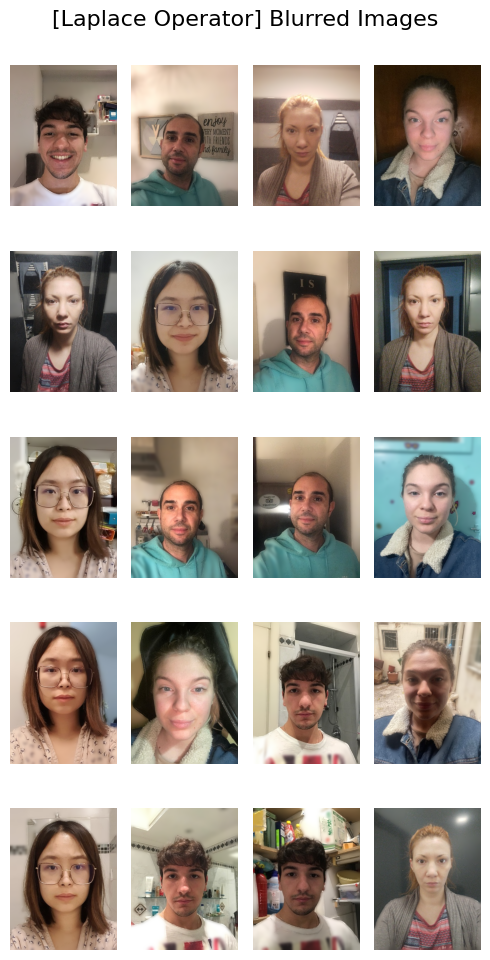

In [24]:
show_subplots("[Laplace Operator] Blurred Images", laplace_blurred)

We then write these results into their own respective folders.

In [25]:
# Create directories for saving the images within main folders 'blurred' and 'masked'
os.makedirs('blurred/canny', exist_ok=True)
os.makedirs('masked/canny', exist_ok=True)
os.makedirs('blurred/sobel', exist_ok=True)
os.makedirs('masked/sobel', exist_ok=True)
os.makedirs('blurred/scharr', exist_ok=True)
os.makedirs('masked/scharr', exist_ok=True)
os.makedirs('blurred/laplace', exist_ok=True)
os.makedirs('masked/laplace', exist_ok=True)

# Save Canny blurred images
for i, img in enumerate(canny_blurred):
    filename = f'blurred/canny/{i:03}.jpeg'
    cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Save Canny masked images
for i, img in enumerate(canny_masked):
    filename = f'masked/canny/{i:03}.jpeg'
    cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Save Sobel blurred images
for i, img in enumerate(sobel_blurred):
    filename = f'blurred/sobel/{i:03}.jpeg'
    cv2.imwrite(filename, cv2.COLOR_RGB2BGR)

# Save Sobel masked images
for i, img in enumerate(sobel_masked):
    filename = f'masked/sobel/{i:03}.jpeg'
    cv2.imwrite(filename, cv2.COLOR_RGB2BGR)

# Save Scharr blurred images
for i, img in enumerate(scharr_blurred):
    filename = f'blurred/scharr/{i:03}.jpeg'
    cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Save Scharr masked images
for i, img in enumerate(scharr_masked):
    filename = f'masked/scharr/{i:03}.jpeg'
    cv2.imwrite(filename, cv2.COLOR_RGB2BGR)

# Save Laplace blurred images
for i, img in enumerate(laplace_blurred):
    filename = f'blurred/laplace/{i:03}.jpeg'
    cv2.imwrite(filename, cv2.COLOR_RGB2BGR)

# Save Laplace masked images
for i, img in enumerate(laplace_masked):
    filename = f'masked/laplace/{i:03}.jpeg'
    cv2.imwrite(filename, cv2.COLOR_RGB2BGR)

## Performance Evaluation

In order to evaluate the performance of the algorithms, we will now compare them by quantitative metrics. Specifically, the averages of execution time, accuracy, specificity, and sensitivity. We will go over the timers first.

### Time Performance

In this section, we will be comparing the time it took for each algorithm to finish. Keep in mind that this time does count the time it took for the algorithm to finish for each channel for Scharr, Laplace, and Sobel. Additionally, the post-processing time is also included for the said methods, as these also count toward the performance of the algorithms.

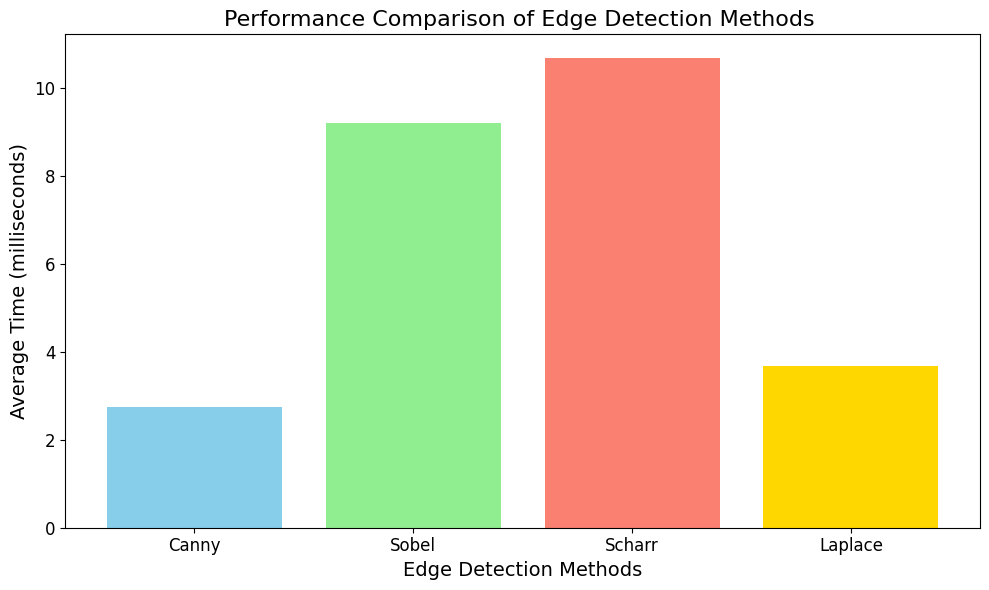

In [32]:
# Extracting the data from the timers dictionary
methods = [method.capitalize() for method in timers.keys()]
times = [time * 1000 for time in timers.values()]  # Convert seconds to milliseconds

# Define distinct colors for each bar
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

# Plotting the performance comparison
plt.figure(figsize=(10, 6))
plt.bar(methods, times, color=colors)
plt.xlabel('Edge Detection Methods', fontsize=14)
plt.ylabel('Average Time (milliseconds)', fontsize=14)
plt.title('Performance Comparison of Edge Detection Methods ', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Mask Performance Evaluation

In [27]:
correct_folder = 'correct_dataset'
correct_imgs = []

filenames = os.listdir(correct_folder)

# Loop over the images in the filenames list and process each image
for filename in sorted(filenames):
    filepath = os.path.join(correct_folder, filename)
    img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

    if img is not None:
        resized = cv2.resize(img, (300, 400))
        
        correct_imgs.append(resized)
    else:
        print(f"{filename} could not be read.")

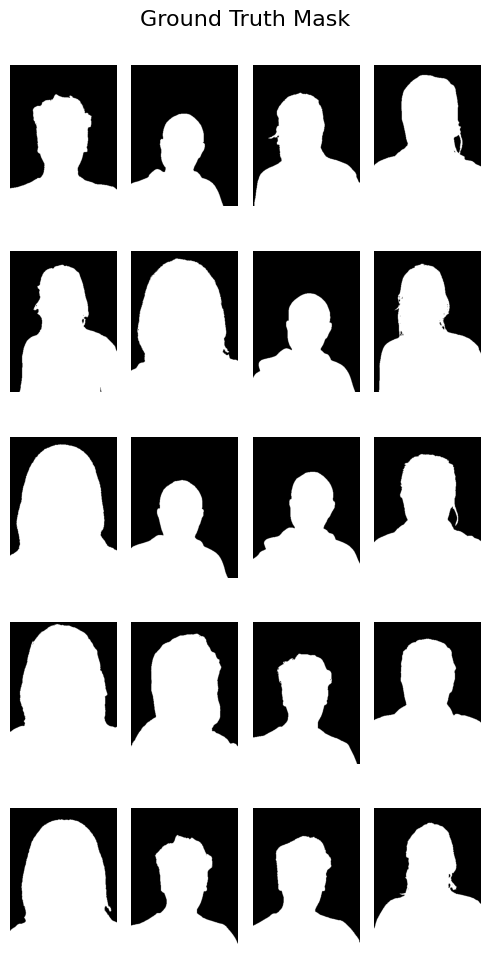

In [28]:
truth_masks = []

for img in correct_imgs:
    alpha_channel = img[:, :, 3]
    _, thresh = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)
    truth_masks.append(thresh)
    
show_subplots("Ground Truth Mask", truth_masks, rgb=False)

In [29]:
def get_metrics(masked_imgs):
    accuracy, specificity, sensitivity = (0, 0, 0)
    
    # Calculate the metrics for each image
    for i, img in enumerate(masked_imgs):
        truth = truth_masks[i]
        _, img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 1, 255, cv2.THRESH_BINARY)
        inverse_img = cv2.bitwise_not(img)
        inverse_truth = cv2.bitwise_not(truth)
        cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
        
        # Calculate true/false pos/neg areas
        tPos = cv2.countNonZero(cv2.bitwise_and(img, truth))
        tNeg = cv2.countNonZero(cv2.bitwise_and(inverse_img, inverse_truth))
        fPos = cv2.countNonZero(cv2.bitwise_and(img, inverse_truth))
        fNeg = cv2.countNonZero(cv2.bitwise_and(inverse_img, truth))
        
        # Add metrics
        accuracy += (tPos + tNeg) / (tPos + tNeg + fPos + fNeg)
        specificity += tNeg / (tNeg + fPos)
        sensitivity += tPos / (tPos + fNeg)
    
    accuracy /= 30
    specificity /= 30
    sensitivity /= 30
    
    return (accuracy, specificity, sensitivity)

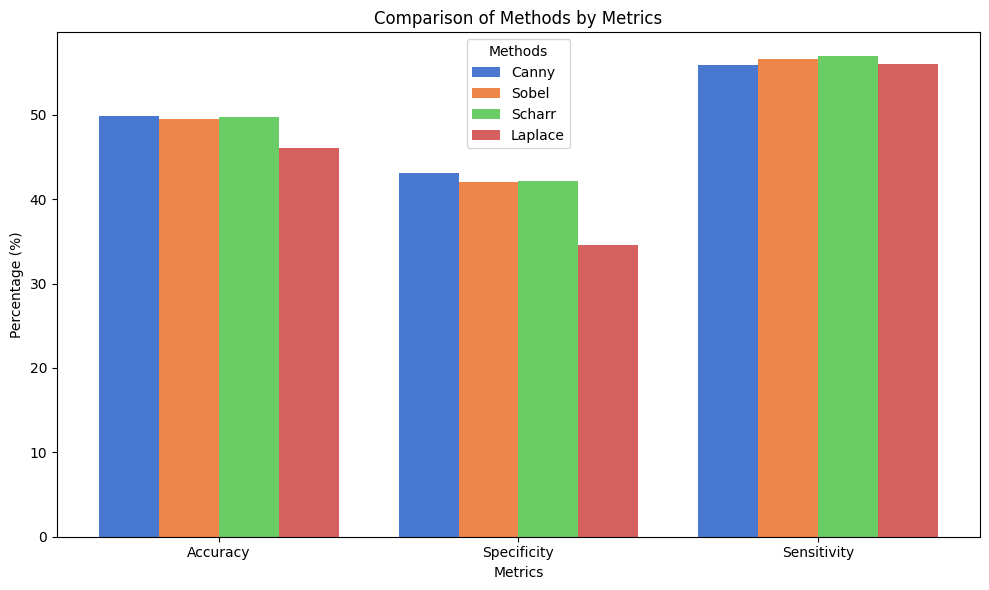

In [30]:
# Calculate metrics for each method
methods = ["Canny", "Sobel", "Scharr", "Laplace"]
metrics = {
    "Accuracy": [],
    "Specificity": [],
    "Sensitivity": []
}

for masked_imgs in [canny_masked, sobel_masked, scharr_masked, laplace_masked]:
    accuracy, specificity, sensitivity = get_metrics(masked_imgs)
    
    # Mutiply by 100 to get the percentage then append
    metrics["Accuracy"].append(accuracy * 100)
    metrics["Specificity"].append(specificity * 100)
    metrics["Sensitivity"].append(sensitivity * 100)

# Seaborn will be used for colors
colors = sns.color_palette("muted", n_colors=len(methods))

# Create the groups inside the plot
metric_labels = list(metrics.keys())
bar_width = 0.2
x = np.arange(len(metric_labels))

# Create the plot
plt.figure(figsize=(10, 6))
for i, (method, color) in enumerate(zip(methods, colors)):
    plt.bar(
        x + i * bar_width,  # Offset each method's bars within the metric group
        [metrics[metric][i] for metric in metric_labels],  # Values for this method
        width=bar_width,
        color=color,
        label=method
    )

plt.xticks(x + bar_width * 1.5, metric_labels)  # Center ticks in the middle of the groups
plt.xlabel("Metrics")
plt.ylabel("Percentage (%)")
plt.title("Comparison of Methods by Metrics")
plt.legend(title="Methods", loc="best")

# Display the graph
plt.tight_layout()
plt.show()

In [31]:
df = pd.DataFrame({"Method": methods, **metrics, "Ave. Execution Time": [f"{time:.2f}ms" for time in times]})
df.iloc[:, 1:4] = df.iloc[:, 1:4].apply(lambda x: x.round(2))

# Display the table
df

Method  Accuracy  Specificity  Sensitivity Ave. Execution Time
0    Canny     49.84        43.06        55.96              2.75ms
1    Sobel     49.45        42.04        56.56              9.20ms
2   Scharr     49.75        42.15        56.93             10.68ms
3  Laplace     46.05        34.54        56.01              3.68ms